In [16]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

np.random.seed(0)

In [17]:
from typing import List, Union, Dict

def MaxEigval(M : np.ndarray) -> np.float32:
        return np.max(np.abs(scipy.linalg.eigvalsh(M)))

def Hessian(X : np.ndarray) -> np.ndarray:
    return (X.T @ X) / X.shape[0]

class RidgeData:
    def FindRidgeOptimal(X : np.ndarray, y : np.ndarray, lam : float) -> np.ndarray:
        return np.linalg.inv(X.T @ X + (lam * X.shape[0]) * np.eye(X.shape[1])) @ X.T @ y
    
    def FindL(X : np.ndarray, lam : float) -> np.float32:
        return MaxEigval(Hessian(X)) + lam
    
    def EstimateAllL(xs : List[np.ndarray], lam : float) -> List[np.float32]:
        return [RidgeData.FindL(np.vstack(xs), lam)] + [RidgeData.FindL(X_i, lam) for X_i in xs]

    def EstimateL(xs : List[np.ndarray], lam : float) -> np.float32:
        return np.max(RidgeData.EstimateAllL(xs, lam))
    
    def EstimateLq(xs : List[np.ndarray], lam : float) -> np.float32:
        return RidgeData.FindL(xs[0], lam)
    
    def EstimateLp(xs : List[np.ndarray], lam : float) -> np.float32:
        HessianP = np.mean([Hessian(X) for X in xs], axis=0) - Hessian(xs[0])
        return MaxEigval(HessianP)
    
    def EstimateDelta(xs : List[np.ndarray]) -> np.float32:
        Hessian_g = Hessian(np.vstack(xs))
        return np.max([MaxEigval(Hessian_g - Hessian(X_i)) for X_i in xs])
    
    def __init__(self, lam : float, num_workers : int, num_feat : int, cnt_worker_data : int):
        self.num_workers = num_workers
        self.num_feat = num_feat
        self.cnt_worker_data = cnt_worker_data
        self.lam = lam

        self.ys = []
        self.xs = []
        w = np.random.normal(size=(num_feat, 1))
        
        for i in range(num_workers):
            if i == 0:
                x = np.random.normal(size=(cnt_worker_data, num_feat))
                self.xs.append(x)
                self.ys.append(x @ w + np.random.normal(size=(cnt_worker_data, 1)))
            else:
                x = self.xs[0] + np.random.normal(size=(cnt_worker_data, num_feat)) * 0.1
                self.xs.append(x)
                self.ys.append(x @ w + np.random.normal(size=(cnt_worker_data, 1)))
            
        self.w_star = RidgeData.FindRidgeOptimal(X = np.vstack(self.xs), y = np.vstack(self.ys), lam=lam)
        self.L = RidgeData.EstimateL(xs=self.xs, lam=lam)
        self.Lp = RidgeData.EstimateLp(xs=self.xs, lam=lam)
        self.Lq = RidgeData.EstimateLq(xs=self.xs, lam=lam)
        self.delta = RidgeData.EstimateDelta(xs=self.xs)
        self.mu = lam
    
    def __repr__(self) -> str:
        return "num_workers: {}; d: {}; cnt_worker_data: {};\ndelta: {}; L: {}; Lp: {}; Lq: {}; mu: {};".format(
                self.num_workers, self.num_feat, self.cnt_worker_data, self.delta, self.L, self.Lp, self.Lq, self.mu
                )

    def Loss(self, w : np.ndarray) -> np.float32:
        y = np.vstack(self.ys)
        X = np.vstack(self.xs)
        return 1 / (2 * X.shape[0]) * (np.linalg.norm(X @ w - y) ** 2) + 1 / (2 * self.lam) * (np.linalg.norm(w) ** 2)
    
    def GetError(self, w : np.ndarray) -> np.float32:
        return np.linalg.norm(w - self.w_star) ** 2

In [37]:

def local_gradient(X : np.ndarray, y : np.ndarray, w : np.ndarray, lam : float) -> np.ndarray:
    return 1/y.shape[0] * (X.T @ X @ w - X.T @ y) + lam * w 


def dummy_gradient(data : RidgeData, K : int = 100, eta : Union[None, float] = None) -> List[np.float32]:
    if eta is None:
        eta = 1 / data.L
    w = np.zeros(shape=(data.num_feat, 1))
    def get_err():
        return np.linalg.norm(w - data.w_star)**2
    start_err = get_err()
    rel_errs = []
    for k in range(K):
        grad = np.mean([local_gradient(X, y, w, data.lam) for X,y in zip(data.xs, data.ys)], axis=0)
        w = w - eta * grad
        rel_errs.append(get_err() / start_err)
    return rel_errs


def AcGD(data : RidgeData, K : int = 100):
    y = w = np.zeros(shape=(data.num_feat, 1))
    k = data.L / data.mu
    start_err = data.GetError(w)
    rel_errs = []

    coef = (np.sqrt(k) - 1) / (np.sqrt(k) + 1)
    
    for k in range(K):
        gradient = np.mean([local_gradient(X, y, w, data.lam) for X,y in zip(data.xs, data.ys)], axis=0)
        y_prev = y
        y = w - (1 / data.L) * gradient
        w = (1 + coef) * y - coef * y_prev
        rel_errs.append(data.GetError(w) / start_err)
    return rel_errs


def AccExtraDefault(data : RidgeData, K : int = 100) -> List[np.float32]:
    def GradientR(w):
        return np.mean([local_gradient(X, y, w, data.lam) for X,y in zip(data.xs, data.ys)], axis=0)

    def GradientQ(w):
        X, y = data.xs[0], data.ys[0]
        return local_gradient(X, y, w, data.lam)
    
    def GradientP(w):
        return GradientR(w) - GradientQ(w)

    theta = 1 / (2 * data.Lp)
    
    def ApproxAmin(x_g):
        T = np.ceil(np.sqrt(3 * (D ** 2) * max(data.Lp, data.Lq) / (data.Lp ** 2)))
    tau = min(1, np.sqrt(data.mu) / (2 * np.sqrt(data.Lp)))
    eta = min(1 / (2 * data.mu), 1 / (2 * np.sqrt(data.mu * data.Lp)))
    alpha = data.mu
    
    x = x_f = np.zeros(shape=(data.num_feat, 1))
    start_err = data.GetError(x)
    rel_errs = []

    for k in range(K):
        x_g = tau * x + (1 - tau) * x_f
        x_f = ApproxAmin(x_g)
        x = x + eta * alpha * (x_f - x) - eta * GradientR(x_f)
        rel_errs.append(data.GetError(x) / start_err)
    return rel_errs 

def AccExtra(data : RidgeData, K : int = 100) -> List[np.float32]:
    def GradientR(w):
        return np.mean([local_gradient(X, y, w, data.lam) for X,y in zip(data.xs, data.ys)], axis=0)

    def GradientQ(w):
        X, y = data.xs[0], data.ys[0]
        return local_gradient(X, y, w, data.lam)
    
    def GradientP(w):
        return GradientR(w) - GradientQ(w)

    theta = 1 / (2 * data.Lp)
    
    def ApproxAmin(x_g):

        x_f = x_g
        eta = 1 / (3 * data.L)
        grad_p_xg = GradientP(x_g)

        
        iters = 0
        tol = 1e-16
        prev = None
        while True:
            grad_a_xf = grad_p_xg + (x_f - x_g) / theta + GradientQ(x_f)
            grad_norm = np.linalg.norm(grad_a_xf)
            if grad_norm <= data.Lp * np.linalg.norm(x_f - x_g) or (prev is not None and prev - grad_norm < tol):
                return x_f
            prev = grad_norm
            iters += 1
            if (iters % 1000 == 0):
                print(np.linalg.norm(grad_a_xf))
                print(np.linalg.norm(x_f - x_g))
            x_f = x_f - eta * grad_a_xf
    
    tau = min(1, np.sqrt(data.mu) / (2 * np.sqrt(data.Lp)))
    eta = min(1 / (2 * data.mu), 1 / (2 * np.sqrt(data.mu * data.Lp)))
    alpha = data.mu
    
    x = x_f = np.zeros(shape=(data.num_feat, 1))
    start_err = data.GetError(x)
    rel_errs = []

    for k in range(K):
        x_g = tau * x + (1 - tau) * x_f
        x_f = ApproxAmin(x_g)
        x = x + eta * alpha * (x_f - x) - eta * GradientR(x_f)
        rel_errs.append(data.GetError(x) / start_err)
    return rel_errs
    

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.size'] = 12
mpl.rcParams['grid.color'] = 'gray'
mpl.rcParams['grid.linestyle'] = '--'

def plot_errs(method_dicts : Dict[str, np.ndarray]):
    for name, errs in method_dicts.items():
        plt.plot(np.mean(errs, axis=1), label=name)
    plt.ylabel("$||w^{n} - w^*||^2 / ||w^0 - w^*||^2$")
    plt.ylim(bottom=1e-8)
    plt.xlabel("$Communications, n$")
    plt.legend()
    plt.yscale('log')
    plt.show()

In [32]:
def MakeExperiment():
    methods = {"Default gradient" : dummy_gradient, "AcGD" : AcGD, "Accelerated Extragradient" : AccExtra}
    data = RidgeData(0.1, num_feat=30, num_workers=25, cnt_worker_data=100)
    print(data)
    plot_errs({key : np.array(method(data=data)).reshape((-1, 1)) for key, method in methods.items()})

num_workers: 25; d: 30; cnt_worker_data: 100;
delta: 0.1789954461218592; L: 2.326849544149411; Lp: 0.04067614320794111; Lq: 2.238963231278463; mu: 0.1;


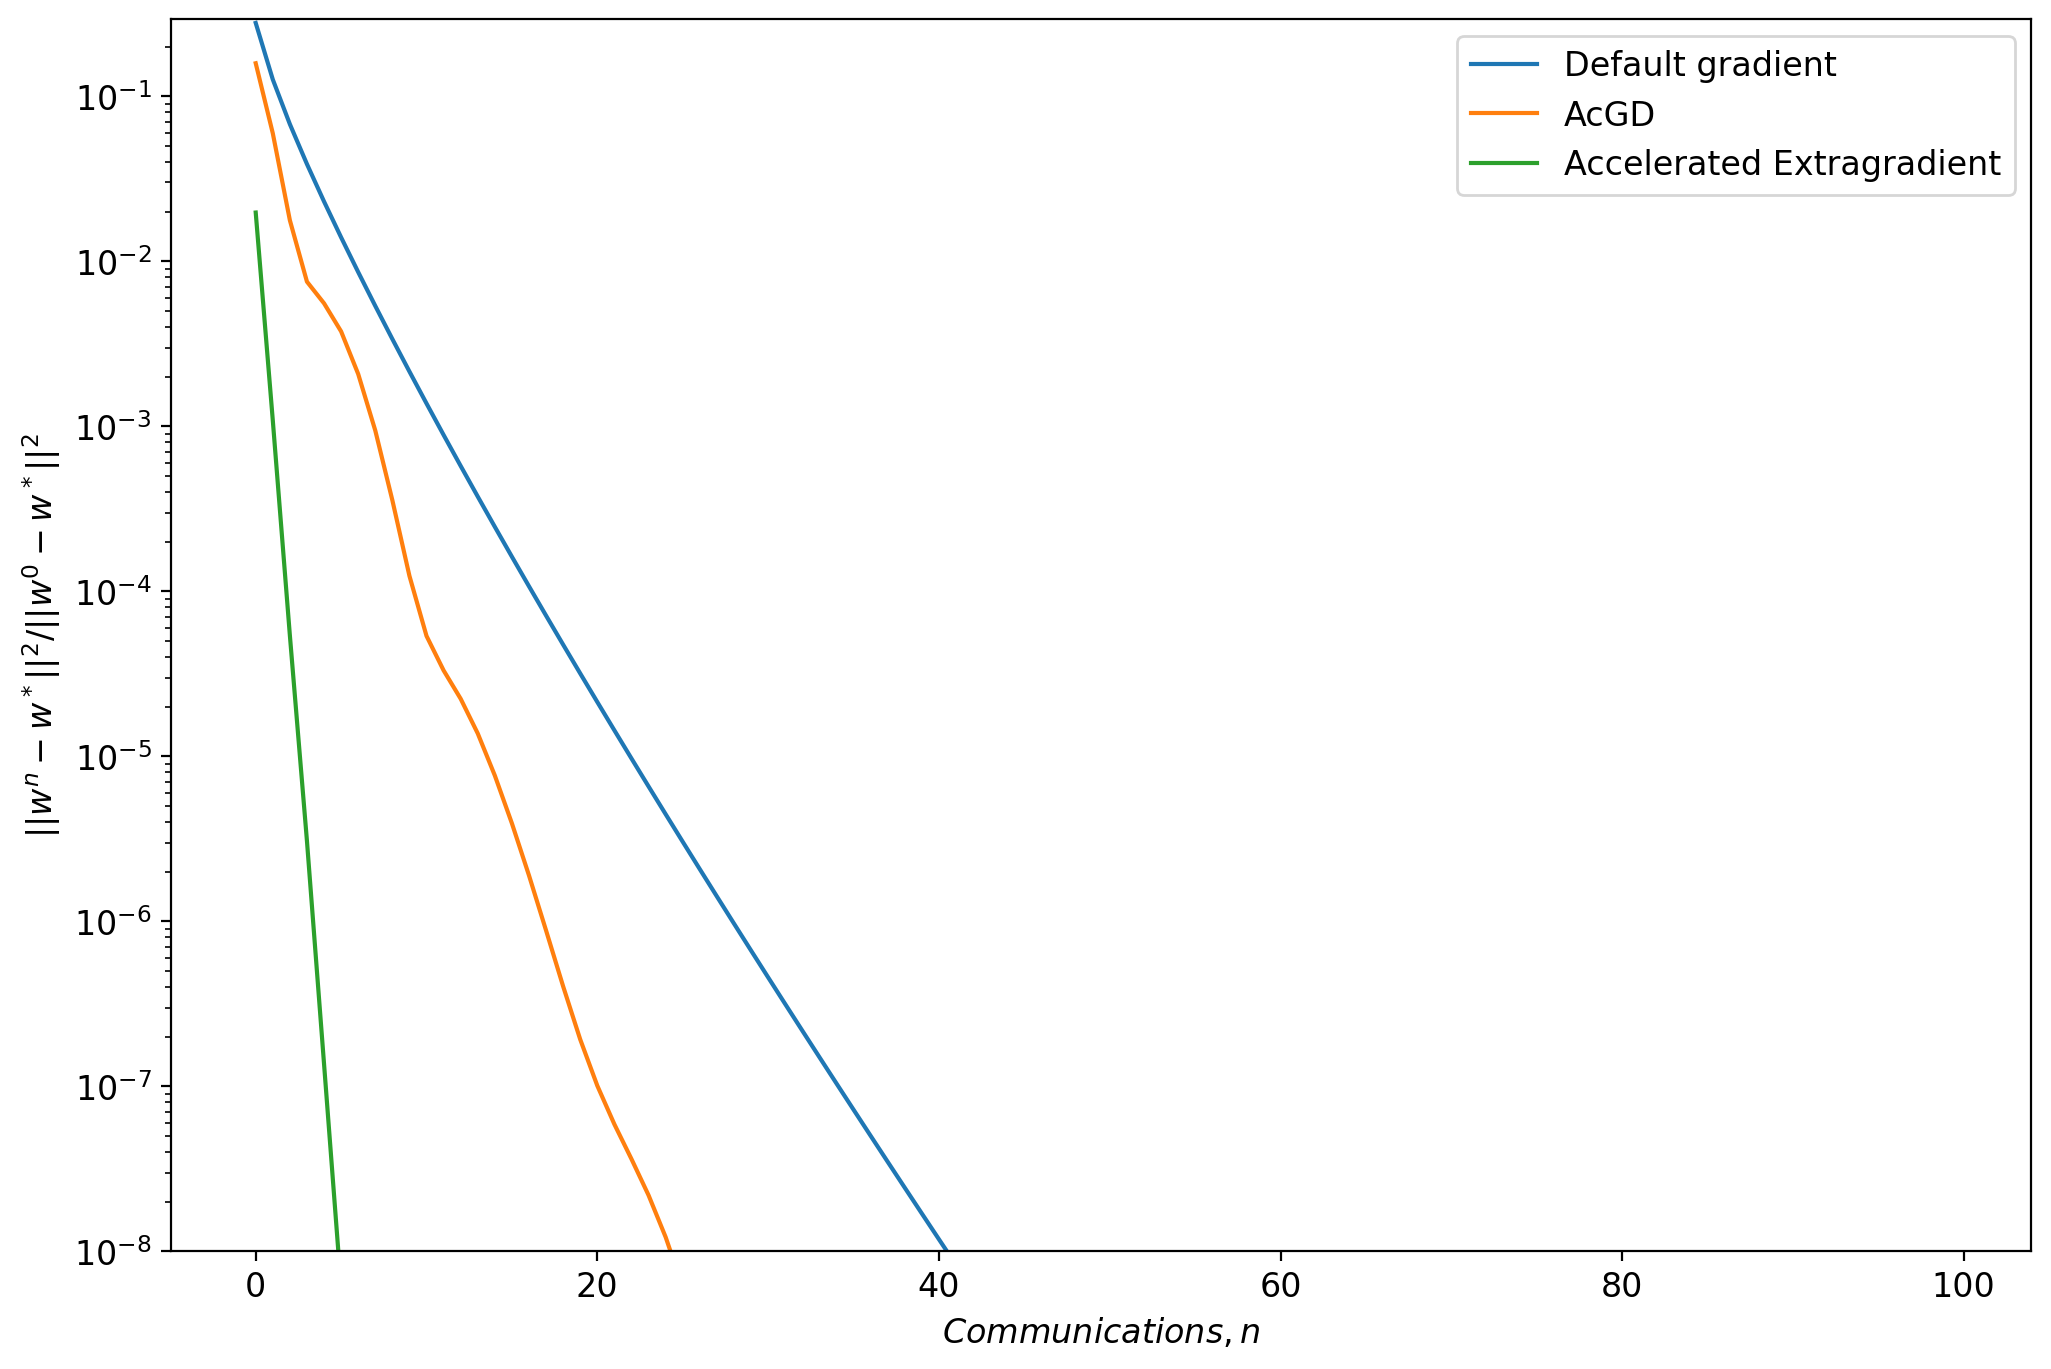

In [35]:
MakeExperiment()